In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
class UserInteraction():
    def __init__(self):
        self.str_q0 = "q0 -"
        self.str_q1 = "q1 -"
        self.wire = "-----------"
        
        #Initial position in grid
        self.i, self.j = [0,1]
        #Creates grid
        '''
        self.grid=np.matrix([[0,0,3,2,0],
                            [1,0,1,0,1],
                            [1,0,0,0,1],
                            [1,1,1,1,1]])
        
        self.grid=np.matrix([[1,0,1,1,1,1,1,1],
                            [1,0,0,0,0,1,1,1],
                            [1,1,1,1,0,1,1,1],
                            [1,1,1,1,0,1,1,1],
                            [1,1,1,1,0,0,0,1],
                            [1,1,1,1,1,1,0,1],
                            [0,2,0,0,0,0,0,1],
                            [1,1,1,1,1,1,1,1]]
)
     '''   
        self.grid=np.matrix([[1,2,1,1,1,1,1,1],
                [1,0,0,0,0,1,1,1],
                [1,1,1,1,0,1,1,1],
                [1,1,1,1,0,1,1,1],
                [1,1,1,1,0,0,0,1],
                [0,0,0,1,1,1,0,1],
                [1,1,0,0,0,0,0,1],
                [1,1,1,1,1,1,1,1]])
        
        self.tun=0
    
    def apply_gates(self):
        print('\n')
        print('--------NEW MOVEMENT--------')
        print("Insert gates you want to apply (Ex: H-X-H-R)")
        
        if level==0:
            q0 = input("q0--")
            q1 = input("q1--")
        elif level==1:
            q0 = input("q0--H-")
            q1 = input("q1--H-")
        elif level==2:
            q0 = input("q0--R-")
            q1 = input("q1-----")
        
        self.gates_q0 = []
        self.gates_q1 = []
        for gate in q0:
            if gate != "-":
                self.gates_q0.append(gate)
        
        for gate in q1:
            if gate != "-":
                self.gates_q1.append(gate)
        
        self.generate_circuit(self.gates_q0,self.gates_q1)
        
        
    def generate_circuit(self,list0, list1):
        circ = QuantumCircuit(2)
        
        if level==0:
            circ.reset(0)
            circ.reset(1)
        elif level==1:
            circ.h(0)
            circ.h(1)
        elif level==2:
            circ.rx(np.pi/2,0)
            circ.reset(1)

        
        #gates q0
        for gate in list0:
            if gate == 'X':
                circ.x(0)
            elif gate == 'H':
                circ.h(0)
            elif gate == 'R':
                circ.rx(np.pi/2,0)
        
        #gates q1
        for gate in list1:
            if gate == 'X':
                circ.x(1)
            elif gate == 'H':
                circ.h(1)
            elif gate == 'R':
                circ.rx(np.pi/2,1)
        
        #Creating the measurement
        meas = QuantumCircuit(2,2)
        meas.barrier(range(2))
        meas.measure(range(2), range(2))
        
        
        self.qc = circ+meas
        print(self.qc)
    
    def movement(self):
        
        
        #Measurement
        simulator = BasicAer.get_backend('qasm_simulator')
        compiled_circuit = transpile(self.qc, simulator)
        
        #initialize dictonary
        counts= {
          "00": 0,
          "01": 0,
          "10": 0,
          "11": 0
        }
     
        counts_total= {
          "00": 0,
          "01": 0,
          "10": 0,
          "11": 0
        }
        # Execute the circuit on the qasm simulator
        job_total = simulator.run(compiled_circuit, shots=1000)
        job = simulator.run(compiled_circuit, shots=1)

        # Grab results from the job
        result = job.result()
        result_total = job_total.result()
        
        # Returns counts
        self.counts = result.get_counts(self.qc)
        self.counts_total = result_total.get_counts(self.qc)
        
        #Movement
        max_counts=900

        #Makes sure to get every state in the dictionary (even if it has 0 counts)
        self.counts_total['00']=self.counts_total.get('00', 0)/1000
        self.counts_total['01']=self.counts_total.get('01', 0)/1000
        self.counts_total['10']=self.counts_total.get('10', 0)/1000
        self.counts_total['11']=self.counts_total.get('11', 0)/1000

        #Makes sure to get every state in the dictionary (even if it has 0 counts)
        self.counts['00']=self.counts.get('00', 0)
        self.counts['01']=self.counts.get('01', 0)
        self.counts['10']=self.counts.get('10', 0)
        self.counts['11']=self.counts.get('11', 0)

        # 00: DOWN
        if self.counts["00"]==1:
            if self.grid[self.i+1,self.j]==0:
                self.grid[self.i,self.j]=0
                self.grid[(self.i+1),self.j]=2
                self.i+=1
            elif self.grid[self.i+1,self.j]==1:
                num_walls = 1
                
                #We check how many walls there are
                for n in range(self.i+2,np.shape(self.grid)[0]):
                    if self.grid[n,self.j]==1:
                        num_walls += 1
                    elif self.grid[n,self.j]==0:
                        #Tunneling is possible
                        self.tun = 1
                        break
                    else:
                        #Tunneling not possible
                        self.tun = 0
                        break
                if self.tun == 1:
                    #If the num of walls is higher then the probability
                    #of tunneling reduces
                    prob = num_walls * 20
                    x = np.random.randint(0,prob)
                    y = np.random.randint(0,prob)
                    if x == y:
                        self.grid[self.i,self.j]=0
                        self.grid[self.i+num_walls+1,self.j]=2
                        self.i+=num_walls+1
                    else:
                        print('Tunneling failed... Try again')
                else:
                    print('Impossible movement. (Tunneling not possible!)')
            else:
                print('Impossible movement')
                

        #01: UP
        elif self.counts["01"]==1:
            if self.grid[self.i-1,self.j]==0:
                self.grid[self.i,self.j]=0
                self.grid[self.i-1,self.j]=2
                self.i += -1
            elif self.grid[self.i-1,self.j]==1:
                num_walls = 1
                
                #We check how many walls there are
                for n in range(2,self.i+1):
                    k = self.i-n
                    if self.grid[n,self.j]==1 and k > 0:
                        num_walls += 1
                    elif self.grid[n,self.j]==0:
                        #Tunneling is possible
                        self.tun = 1
                        break
                    else:
                        #Tunneling not possible
                        self.tun = 0
                        break
                if self.tun == 1:
                    #If the num of walls is higher then the probability
                    #of tunneling reduces
                    prob = num_walls * 20
                    x = np.random.randint(0,prob)
                    y = np.random.randint(0,prob)
                    if x == y:
                        self.grid[self.i,self.j]=0
                        self.grid[self.i-num_walls-1,self.j]=2
                        self.i+=-(num_walls+1)
                    else:
                        print('Tunneling failed... Try again')
                else:
                    print('Impossible movement. (Tunneling not possible!)')
            else:
                print('Impossible movement')
                
                
        #10: RIGHT        
        elif self.counts["10"]==1:
            if self.grid[self.i,self.j+1]==0:
                self.grid[self.i,self.j]=0
                self.grid[self.i,self.j+1]=2
                self.j += 1
            elif self.grid[self.i,self.j+1]==1:
                num_walls = 1
                
                #We check how many walls there are
                for n in range(self.j+2,np.shape(self.grid)[1]):
                    if self.grid[self.i,n]==1:
                        num_walls += 1
                    elif self.grid[self.i,n]==0:
                        #Tunneling is possible
                        self.tun = 1
                        break
                    else:
                        #Tunneling not possible
                        self.tun = 0
                        break
                if self.tun == 1:
                    #If the num of walls is higher then the probability
                    #of tunneling reduces
                    prob = num_walls * 20
                    x = np.random.randint(0,prob)
                    y = np.random.randint(0,prob)
                    if x == y:
                        self.grid[self.i,self.j]=0
                        self.grid[self.i,self.j+num_walls+1]=2
                        self.j+=num_walls+1
                    else:
                        print('Tunneling failed... Try again')
                else:
                    print('Impossible movement. (Tunneling not possible!)')
            else:
                print('Impossible movement')

        #11: LEFT
        elif self.counts["11"]==1:
            if self.grid[self.i,self.j-1]==0:
                self.grid[self.i,self.j]=0
                self.grid[self.i,self.j-1]=2
                self.j += -1
            elif self.grid[self.i,self.j-1]==1:
                num_walls = 1
                
                #We check how many walls there are
                for n in range(2,self.j+1):
                    k = self.j-n
                    if self.grid[self.i,n]==1 and k > 0:
                        num_walls += 1
                    elif self.grid[self.i,n]==0:
                        #Tunneling is possible
                        self.tun = 1
                        break
                    else:
                        #Tunneling not possible
                        self.tun = 0
                        break
                if self.tun == 1:
                    #If the num of walls is higher then the probability
                    #of tunneling reduces
                    prob = num_walls * 20
                    x = np.random.randint(0,prob)
                    y = np.random.randint(0,prob)
                    if x == y:
                        self.grid[self.i,self.j]=0
                        self.grid[self.i,self.j-num_walls-1]=2
                        self.i+=-(num_walls+1)
                    else:
                        print('Tunneling failed... Try again')
                else:
                    print('Impossible movement. (Tunneling not possible!)')
            else:
                print('Impossible movement')
        
        keys = self.counts_total. keys()
        values = self.counts_total. values()
        histo=plt. bar(keys, values)
        plt.xlabel('States', fontsize = 10)
        plt.ylabel('Probabilities', fontsize = 10)
       
        #histo=plt.bar(list(self.counts_total()), self.counts_total.values(), color='g')
        
        #print(self.grid)
        #print(plt. bar(keys, values))
        return self.grid, plt. show(histo)


Initial position:
[[1 2 1 1 1 1 1 1]
 [1 0 0 0 0 1 1 1]
 [1 1 1 1 0 1 1 1]
 [1 1 1 1 0 1 1 1]
 [1 1 1 1 0 0 0 1]
 [0 0 0 1 1 1 0 1]
 [1 1 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1]]


--------NEW MOVEMENT--------
Insert gates you want to apply (Ex: H-X-H-R)
q0--X
q1--X


<ipython-input-2-920eb6d54a2b>:103: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self.qc = circ+meas
C:\Users\Berta\Documents\Anaconda\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


          ┌───┐ ░ ┌─┐   
q_0: ─|0>─┤ X ├─░─┤M├───
          ├───┤ ░ └╥┘┌─┐
q_1: ─|0>─┤ X ├─░──╫─┤M├
          └───┘ ░  ║ └╥┘
c: 2/══════════════╩══╩═
                   0  1 
Impossible movement. (Tunneling not possible!)


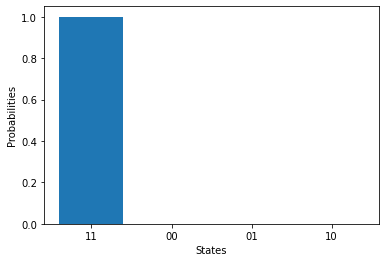

(matrix([[1, 2, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]]), None)


--------NEW MOVEMENT--------
Insert gates you want to apply (Ex: H-X-H-R)
q0--
q1--
           ░ ┌─┐   
q_0: ─|0>──░─┤M├───
           ░ └╥┘┌─┐
q_1: ─|0>──░──╫─┤M├
           ░  ║ └╥┘
c: 2/═════════╩══╩═
              0  1 


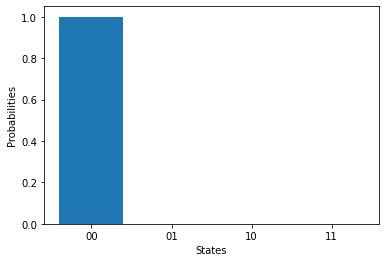

(matrix([[1, 0, 1, 1, 1, 1, 1, 1],
        [1, 2, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]]), None)


--------NEW MOVEMENT--------
Insert gates you want to apply (Ex: H-X-H-R)
q0--X
q1--
          ┌───┐ ░ ┌─┐   
q_0: ─|0>─┤ X ├─░─┤M├───
          └───┘ ░ └╥┘┌─┐
q_1: ─|0>───────░──╫─┤M├
                ░  ║ └╥┘
c: 2/══════════════╩══╩═
                   0  1 


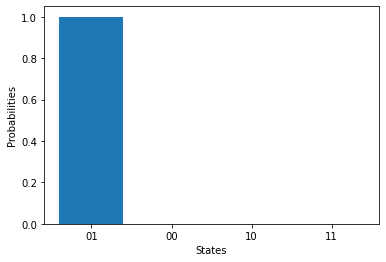

(matrix([[1, 2, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 1, 1, 1, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]]), None)


--------NEW MOVEMENT--------
Insert gates you want to apply (Ex: H-X-H-R)


In [ ]:
level=0

for level in range(3):
    A = UserInteraction()
    print('Initial position:\n{}'.format(A.grid))
    while A.grid[5,0] != 2:
        A.apply_gates()
        print(A.movement())    
    if level==0: 
        print('\n')
        print('Congratulations!! You win!! ')
        print('NEXT LEVEL')
        print('\n')
    elif level==1:
        print('\n')
        print('Congratulations!! You win!! ')
        print('NEXT LEVEL')
        print('\n')
    #level=level+1
    
print("Congratulations!!  You win!! ")
print('END OF THE GAME')